In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# from bokeh.models import HoverTool, ColumnDataSource
# from bokeh.palettes import Viridis6
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.sampledata.us_counties import data as counties
# from bokeh.sampledata.unemployment import data as unemployment

In [4]:
sample = pd.read_csv('data/part1data1.txt', names=['Population', 'Benefit'])
sample.head()

,Population,Benefit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


# 1.1 Visualization

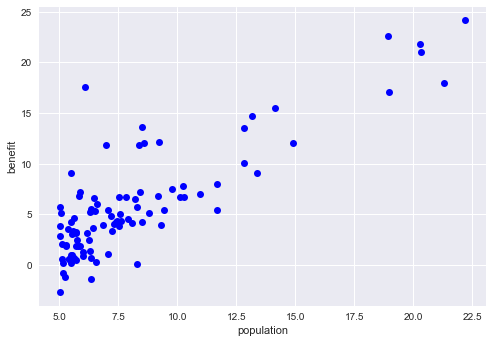

In [5]:
plt.plot(sample.ix[:,0], sample.ix[:,1], 'bo')
plt.xlabel('population')
plt.ylabel('benefit')

In [6]:
data = sample
n = 2
m = data.shape[0]
scaleInfo = []

x = data.ix[:, :n-1]
x = np.concatenate((np.ones((1,m)), x.T)).T

for i in range(0, n):
    scaleInfo.append( [ x[:,i].min(), x[:,i].mean(), x[:,i].max()] )
    
for i in range(1, n):
    for j in range(0, m):
        r = scaleInfo[i][2] - scaleInfo[i][0]
        if r != 0:
            x[j][i] = ( x[j][i] - scaleInfo[i][1] ) / r
        else:
            x[j][i] = ( x[j][i] - scaleInfo[i][1] ) / 1

y = np.array( data.ix[:,-1] )
y = y.T

# print(x)
# print(y)

# 1.2 Gradient Descent

In [7]:
def cost(dataX, dataY, t):
    h = np.dot(dataX , t)
    loss = h - dataY
    return abs(np.array(loss)).sum()

In [8]:
print( cost(x,y,[0,0]) )

578.52528


theta: [  5.83913505  19.19972394]


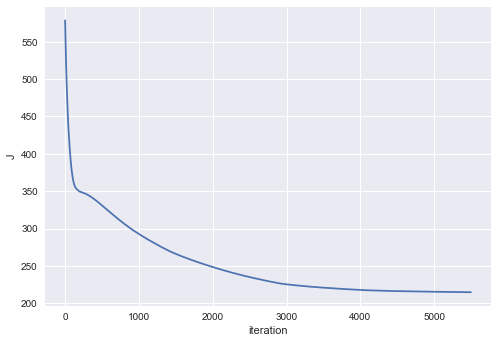

In [9]:
def findRegression(dataX, dataY):
    autoAlphaSelect = True
    iterCount = 5500
    alpha = .01
    theta = np.array(n * [0])

    j = []
    complete = False

    while( not complete ):
        complete = True
        for _ in range(0, iterCount):
            h = np.dot(dataX , theta)
            loss = h - dataY
            gradient = np.dot(loss , dataX)
            theta = theta - alpha / m * gradient
            j += [ abs(np.array(loss)).sum() ]

            # fix big alpha
            if ( autoAlphaSelect and j[ len(j)-1 ] > j[ len(j)-2 ]):
                complete = False
                alpha = alpha / 10
#                 print('alpha:', alpha)
                theta = np.array(n * [0])
                j.clear()
                break
    return theta, j
                
theta, j = findRegression(x, y)
print('theta:', theta )

plt.plot(j)
plt.xlabel('iteration')
plt.ylabel('J')

# TODO

# به تصویر کشیدن تابع هزینه - امتیازی

(600, 600)


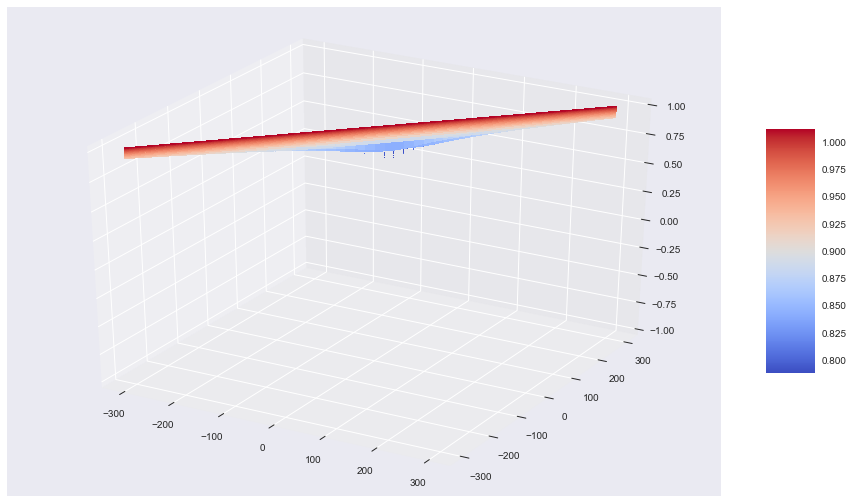

In [10]:
fig = plt.figure(figsize=(16,9))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-300, 300, 1)
Y = np.arange(-300, 300, 1)
# X, Y = np.meshgrid(X, Y)

res = []
for i in X:
    for j in Y:
        res += [cost(x, y, [i,j])]

# R = np.sqrt(X**2)
res = np.array(res)
res = res.reshape( 600,600 )
print( res.shape )
Z = np.log10( np.log( res ) )

# X = np.arange(-5, 5, 0.25)
# Y = np.arange(-5, 5, 0.25)
# X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# # Z = np.sin(R)
# Z = np.cos(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
# print( X )
# print("---")
# print( Y )
# print("---")
# print( Z )

In [11]:
def scale(a, scaleInfo):
    result = [1]
    for i in range(1, n):
        r = scaleInfo[i][2] - scaleInfo[i][0]
        if r != 0:
            result += [( a[i-1] - scaleInfo[i][1] ) / r]
        else:
            result += [( a[i-1] - scaleInfo[i][1] ) / 1]
    return result

(5.0269000000000004, 2.337128477420229) (22.203000000000003, 21.536852413022277)


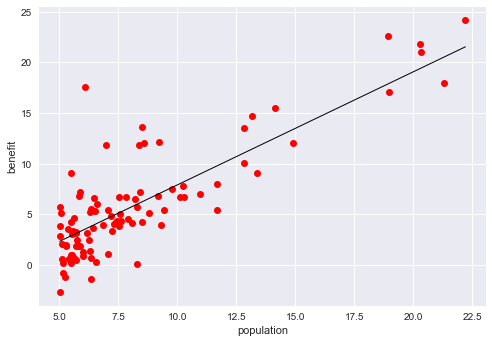

In [12]:
tableMin = sample.ix[:, 0].min()
tableMax = sample.ix[:, 0].max()

a = (tableMin, np.array(scale([tableMin], scaleInfo)).dot(theta))
b = (tableMax, np.array(scale([tableMax], scaleInfo)).dot(theta))

print( a, b)
            
plt.plot(sample.ix[:,0], sample.ix[:,1], 'ro')
plt.plot([ a[0], b[0] ], [ a[1], b[1] ], 'k-', lw=1)
plt.xlabel('population')
plt.ylabel('benefit')

# RANSAC (امتیازی)

In [13]:
iteration = 100
sampleCount = m * 60 // 100
errorSize = 5

bestFit = 0
bestTheta = None
bestIndex = None
bestJ = None

def findInlinesCount(dataX, dataY, sampleTetha, error):
    dataSize = len(dataY)
    count = 0
    for i in range( dataSize ):
        diff = abs( np.dot(np.array(sampleTetha), np.array(dataX[i])) - dataY[i] )
        if diff < errorSize:
            count += 1
    return count
    
for i in range(iteration):
    sampleDataIndex = random.sample( range(m), sampleCount)
    sampleX = x[ sampleDataIndex ]
    sampleY = y[ sampleDataIndex ]
    sampleTetha, sampleJ = findRegression( sampleX, sampleY )
    
    inlineCound = findInlinesCount(x, y, sampleTetha, errorSize)
    if inlineCound > bestFit:
        bestFit = inlineCound
        bestTheta = sampleTetha
        bestIndex = sampleDataIndex
        bestJ = sampleJ

(5.0269000000000004, 1.9464972465347765) (22.203000000000003, 20.28950257933122)
88


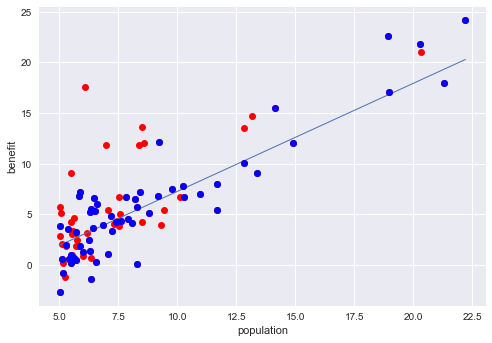

In [14]:
a = (tableMin, np.array(scale([tableMin], scaleInfo)).dot(bestTheta))
b = (tableMax, np.array(scale([tableMax], scaleInfo)).dot(bestTheta))

print( a, b)
print( bestFit )
            
plt.plot(sample.ix[:,0], sample.ix[:,1], 'ro')
plt.plot([ a[0], b[0] ], [ a[1], b[1] ], '-', lw=1)
plt.plot(sample.ix[bestIndex,0], sample.ix[bestIndex,1], 'bo')
plt.xlabel('population')
plt.ylabel('benefit')